# BERTopic

### Import data and libraries

In [1]:
import pandas as pd
from bertopic import (
    BERTopic,
)
import matplotlib.pyplot as plt
import time

/Users/alvarodda/Library/Caches/pypoetry/virtualenvs/nlp-group-wv9ExQSa-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("steam_reviews.csv")

### EDA

In [3]:
df.head(3)

,date_posted,funny,helpful,hour_played,is_early_access_review,recommendation,review,title
0,2019-02-10,2,4,578,False,Recommended,&gt Played as German Reich&gt Declare war on B...,Expansion - Hearts of Iron IV: Man the Guns
1,2019-02-10,0,0,184,False,Recommended,yes.,Expansion - Hearts of Iron IV: Man the Guns
2,2019-02-07,0,0,892,False,Recommended,Very good game although a bit overpriced in my...,Expansion - Hearts of Iron IV: Man the Guns


In [4]:
# shape, columns, data types
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}\n")
print(71 * "-")
print(f"\nColumns: {df.columns}\n")
print(71 * "-")
print(f"Data Types: \n{df.dtypes}\n")

Rows: 434891, Columns: 8

-----------------------------------------------------------------------

Columns: Index(['date_posted', 'funny', 'helpful', 'hour_played',
       'is_early_access_review', 'recommendation', 'review', 'title'],
      dtype='object')

-----------------------------------------------------------------------
Data Types: 
date_posted               object
funny                      int64
helpful                    int64
hour_played                int64
is_early_access_review      bool
recommendation            object
review                    object
title                     object
dtype: object



In [5]:
# number of games
n_games = len(df["title"].unique())
print(f"Number of games: {n_games}")

Number of games: 48


In [6]:
""" 
By looking at the cumulative number of reviews as well as the cumulative percentage coverered we can decide how many game to analyze. 
Based on the results it seems reasonable to analyze the first three games, as this covers 93.55%, respectively 97.79%, of reviews. 
The remainding games could be dropped. 
"""

review_counts = (
    df["title"].value_counts().reset_index()
)  # reset_index() to convert series to df
review_counts.columns = ["game", "number of reviews"]  # renaming the columns of the df

# total number of reviews
total_reviews = review_counts["number of reviews"].sum()

# cumulative sum of reviews
review_counts["cumulative reviews"] = review_counts[
    "number of reviews"
].cumsum()  # adding a new column to the df

# cumulative percentage -> cumulative reviews / total number of reviews
review_counts["cumulative percentage"] = round(
    (review_counts["cumulative reviews"] / total_reviews) * 100, 2
)  # adding a new column to the df

# results
review_counts.head(10)

,game,number of reviews,cumulative reviews,cumulative percentage
0,PLAYERUNKNOWN'S BATTLEGROUNDS,145685,145685,33.50
1,Grand Theft Auto V,99956,245641,56.48
2,Rust,71088,316729,72.83
3,Rocket League®,67907,384636,88.44
4,Dead by Daylight,22221,406857,93.55
5,MONSTER HUNTER: WORLD,18412,425269,97.79
6,ASTRONEER,2661,427930,98.40
7,The Elder Scrolls V: Skyrim Special Edition,1473,429403,98.74
8,RESIDENT EVIL 2 / BIOHAZARD RE:2,1385,430788,99.06
9,Sid Meier’s Civilization® VI,522,431310,99.18


### Preprocessing

BERTopic requires almost no preprocessing. However, the following steps are performed: 
- Missing values
- Duplicates
- Filtering data for top n-games (to analyze specifc games and not the whole dataset) 

In [7]:
# missing values
print(f"Missing values: \n{df.isna().sum()}")

Missing values: 
date_posted                  0
funny                        0
helpful                      0
hour_played                  0
is_early_access_review       0
recommendation               0
review                    1516
title                        0
dtype: int64


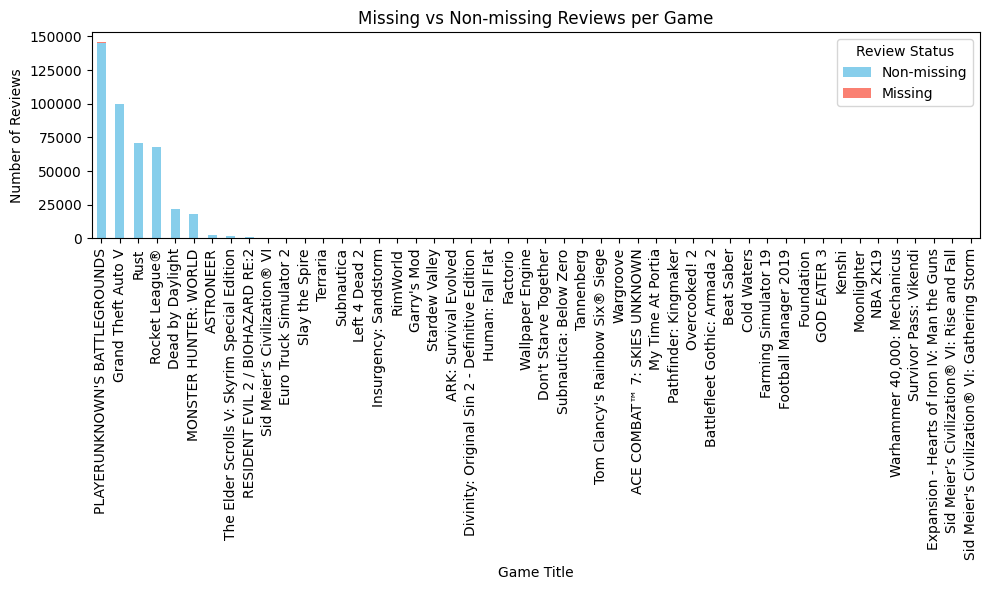

In [8]:
""" 
We see above that there are almost no missing values. To put the number into perspective, the following chart shows the number of 
non-missing and missing values per game. 
In conclusion, we subsequently simply drop all reviews with missing values.
"""

# adding a column for the missing reviews
df["review_missing"] = df["review"].isna()

# Group by 'title' and 'review_missing' to count the occurrences
missing_data = df.groupby(["title", "review_missing"]).size().unstack(fill_value=0)

# calculating the total number of reviews (missing + non-missing) for sorting
missing_data["total_reviews"] = missing_data.sum(axis=1)
missing_data = missing_data.sort_values(by="total_reviews", ascending=False)
missing_data = missing_data.drop(
    columns="total_reviews"
)  # dropping the column we created - we dont need it anymore
df.drop(columns="review_missing", inplace=True)  # we also dont need this one anymore

# plot
missing_data.plot(
    kind="bar", stacked=True, figsize=(10, 6), color=["skyblue", "salmon"]
)

plt.title("Missing vs Non-missing Reviews per Game")
plt.xlabel("Game Title")
plt.ylabel("Number of Reviews")
plt.legend(["Non-missing", "Missing"], title="Review Status")
plt.tight_layout()

plt.show()

In [9]:
df = df.dropna()  # reviews is the only feature with missing values (1516)

In [10]:
# drop duplicate rows
initial_row_count = df.shape[0]
df = df.drop_duplicates()
final_row_count = df.shape[0]

duplicates_removed = initial_row_count - final_row_count

print(f"Number of duplicate rows removed: {duplicates_removed}")

Number of duplicate rows removed: 0


In [11]:
# setting up dfs for the top 5 games and keeping only the reviews
df_1 = df[df["title"] == "PLAYERUNKNOWN'S BATTLEGROUNDS"]["review"]
df_2 = df[df["title"] == "Grand Theft Auto V"]["review"]
df_3 = df[df["title"] == "Rust"]["review"]
df_4 = df[df["title"] == "Rocket League®"]["review"]
df_5 = df[df["title"] == "Dead by Daylight"]["review"]

### Analysis

In [21]:
# Start timer
start_time = time.time()

# initializing models
topic_model_1 = BERTopic(
    embedding_model="all-MiniLM-L6-v2", n_jobs=-1
)  # we could try different models if we want to
topic_model_2 = BERTopic(embedding_model="all-MiniLM-L6-v2", n_jobs=-1)
topic_model_3 = BERTopic(embedding_model="all-MiniLM-L6-v2", n_jobs=-1)

# fitting the models
topics_1, probs_1 = topic_model_1.fit_transform(df_1)
topics_2, probs_2 = topic_model_2.fit_transform(df_2)
topics_3, probs_3 = topic_model_3.fit_transform(df_3)

# Save the fitted models
topic_model_1.save("topic_model_PUBG")
topic_model_2.save("topic_model_GTA")
topic_model_3.save("topic_model_RUST")

# End timer
end_time = time.time()
duration = end_time - start_time
print(f"Time taken: {duration} seconds")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Time taken: 58.31421780586243 seconds


Load the saved models:

topic_model_1 = BERTopic.load("topic_model_PUBG")

topic_model_2 = BERTopic.load("topic_model_GTA")

topic_model_3 = BERTopic.load("topic_model_RUST")

In [23]:
df_topics = topic_model_1.get_topic_info()
df_topics.head(20)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,7530,-1_the_to_and_of,"[the, to, and, of, you, it, is, game, that, this]",[Product received for free. Before I start off...
1,0,510,0_you_in_to_or,"[you, in, to, or, the, and, of, be, is, are]",[Even though PlayerUnknown s Battlegrounds is ...
2,1,476,1_fps_pc_gtx_low,"[fps, pc, gtx, low, ram, settings, 60, run, ru...",[whoever made this game I play on 8gb RAM i5 6...
3,2,337,2_crash_crashes_crashing_loading,"[crash, crashes, crashing, loading, fix, error...","[why this game always crash, Crash Crash Crash..."
4,3,280,3_pubg_you_it_is,"[pubg, you, it, is, friends, of, in, and, the,...",[So PUBG is a battle royale game that throws y...
5,4,272,4_bugs_bug_fix_buggy,"[bugs, bug, fix, buggy, still, full, but, fun,...","[Bugs Bugs Bugs ...., BUGS BUGS AND BUGS, Bugs..."
6,5,262,5_hackers_hacker_hacking_many,"[hackers, hacker, hacking, many, game, every, ...","[hackers every game, in 5 games 3 hackers, hac..."
7,6,255,6_received_product_free_for,"[received, product, free, for, very, game, thi...","[Product received for free. It's good game, Pr..."
8,7,184,7_bluehole_hole_they_company,"[bluehole, hole, they, company, fixing, this, ...",[i love this game i really do but you bluehole...
9,8,175,8_microtransactions_micro_transactions_access,"[microtransactions, micro, transactions, acces...","[microtransactions, Early access with microtra..."


## Topic Modeling Summary

### Key Themes and Insights

1. **Common Issues and Complaints:**
    - Crashes and Bugs:
        - Topics 2, 3, and 18 indicate significant issues with crashes, bugs, and stability.
        - Users frequently mention "crash", "bugs", and "buggy" in their feedback. 
        - Players are frustrated with the game's stability. Frequent crashes and persistent bugs detract from the overall gaming experience. This is a critical issue that needs addressing to improve user satisfaction.

2. **Gameplay Experience:**
    - Hackers and Cheaters:
        - Topic 1 highlights the prevalence of hackers and hacking in the game, which severely impacts the gameplay experience.
        - Frequent words: "hackers", "hacker", "hacking".
        - The presence of hackers is a significant problem. Many users report encountering hackers in almost every game, which undermines fair play and enjoyment.
    - Microtransactions and Early Access:
        - Topic 10 addresses concerns about microtransactions and their impact on the game's accessibility.
        - Topic 12 discusses the pros and cons of early access, with mixed reviews from players.
        - Players have mixed feelings about microtransactions, with some feeling that they hinder the game's accessibility. Early access is appreciated by some, but others feel the game is still not ready for full release.

3. **Player Interaction and Community:**
    - Playing with Friends:
        - Topic 5 emphasizes the fun aspect of playing with friends, showing that social interaction is a strong positive aspect, encouraging continued play.
        - Topic 17 also highlights the enjoyment of solo, squad, and duo gameplay modes. This also shows the importance of having different gamemodes. 
    - Language and Communication:
        - Topic 16 mentions issues related to language barriers, particularly between English and Chinese-speaking players. This affects teamwork and the overall multiplayer experience.

**Conclusion**

The key areas of concern include technical issues (crashes and bugs), unfair play (hackers), and monetization practices (microtransactions). However, the game's social aspects and variety in gameplay modes are well-received by players. Addressing these concerns can significantly improve the overall user experience.



### Further Analysis

In [14]:
for i in 0, 1, 2, 3, 5:
    print(topic_model_1.get_representative_docs(i))

['This game is ****ing dog ****. Actually dog **** is probably better as it serves some purpase in fertilizing the ground the dog ****s on. This game is built on a broken engine with an uncountable number of bugs and glitches. I think the dev smashed his head on the keyboard hoping a solided coded foundation would come out and instead he accidentally smashed PUBG into existence. There is no attempt by the dev team to fix the game. Either their code is so seriously flawed that they cannot fix it they do not care and will not fix it or my personal opinion they are not skilled enough to fix it.I normally do not write reviews but this level of incompetence and failure deserves the time and effort. A few problems with this game 1) The main focus is entirely wrong. Do you like finding guns and shooting people winning by pure skill alone? Well **** off this game is not for you. The game is deviod of loot. The odds of you finding a gun in the first 3 houses you loot are slim. The major problem

In [15]:
topic_model_1.visualize_topics()

In [16]:
topic_model_1.visualize_barchart()

In [19]:
# Add the topic labels to the DataFrame
df_1_subset = df_1.iloc[:20_000].copy()
type(df_1_subset)

df_1_subset = pd.DataFrame(df_1_subset).reset_index()
df_1_subset["topic"] = topics_1
df_1_subset

bug_reviews = df_1_subset[df_1_subset["topic"] == 4]
bug_reviews

# instantiating and fitting model
topic_model_bugs = BERTopic(embedding_model="all-MiniLM-L6-v2")
topics_bugs, probs_bugs = topic_model_bugs.fit_transform(bug_reviews["review"])

# getting results
topic_model_bugs.get_topic_info()
topic_model_bugs

,Topic,Count,Name,Representation,Representative_Docs
0,-1,107,-1_game_the_and_you,"[game, the, and, you, it, is, pubg, to, of, but]",[PUBG is a really fun game. It's really fun fo...
1,0,85,0_the_to_and_of,"[the, to, and, of, game, you, it, is, in, this]",[From a gameplay and spectator perspective PUB...
2,1,51,1_the_game_pubg_and,"[the, game, pubg, and, is, to, it, but, that, of]",[They ruined the feel of what pubg is supposed...
3,2,17,2_it_this_pubg_game,"[it, this, pubg, game, is, and, buy, the, to, ...",[Before owning PUBG I knew I was going to buy ...


In [20]:
for i in 0, 1:
    print(len(topic_model_bugs.get_representative_docs(i)))

3
3


In [3]:
import pandas as pd

# load csv
PUBG_results_df = pd.read_csv("PUBG_results.csv")
GTA_results_df = pd.read_csv("GTA_results.csv")
RUST_results_df = pd.read_csv("RUST_results.csv")

### Chatgpt Integration

In [16]:
from typing import Any
from openai import OpenAI
import instructor
from pydantic import BaseModel
from keys import openai_key
import os

os.environ["OPENAI_API_KEY"] = openai_key


class Answer(BaseModel):
    answer_str: str
    sentiment_score: float


def call_chatgpt(
    system_prompt: str,
    user_prompt: str,
    temp: float = 0.5,
    model: str = "gpt-4o",
) -> Any:

    try:
        client = instructor.patch(OpenAI())
        response = client.chat.completions.create(
            model=model,
            temperature=temp,
            response_model=Answer,
            messages=[
                {
                    "role": "system",
                    "content": system_prompt,
                },
                {"role": "user", "content": user_prompt},
            ],
        )

    except Exception as e:
        print(f"An exception occurred while calling OpenAI API: {e}")
        raise e

    return response

In [43]:
# Removing the first row
PUBG_results_df = PUBG_results_df.iloc[1:]
PUBG_results_df.head(11).to_csv("PUBG_results_top10.csv", index=False)

In [32]:
system_promt = """You are an assistant whose job is to write a 5 lines informative summary based on the content of Steam {videogame} reviews provided by the user. The summary should be descriptive and informative, allowing someone to fully understand the overall sentiment and key points discussed in the reviews. Additionally, include a score from 1 to 10, where 1 indicates highly negative reviews and 10 indicates highly positive reviews. Do not explain what the game is; assume the reader is already familiar with it."""

user_promt = """Topic Name: {topic_name}\n 
------------------ \n
Most common words: {most_common_words}\n
------------------ \n
Most representative reviews: {most_common_reviews}
"""


def get_topic_summary(
    game_name, system_promt, topic_name, most_common_words, most_common_reviews
):
    user_prompt = f"""
    Topic Name: {topic_name}
    Most Common Words: {most_common_words}
    Most Common Reviews: {most_common_reviews}
    """
    print(user_prompt)
    formatted_prompt = system_promt.format(videogame=game_name)

    response = call_chatgpt(formatted_prompt, user_prompt)
    return response.answer_str, response.sentiment_score


def process_topic_results(df, game_name):
    summaries = []
    for index, row in list(df.iterrows())[1:6]:
        topic_name = row["Name"]
        most_common_words = row["Representation"]
        most_common_reviews = row["Representative_Docs"]
        print(
            game_name, system_promt, topic_name, most_common_words, most_common_reviews
        )

        summary = get_topic_summary(
            game_name, system_promt, topic_name, most_common_words, most_common_reviews
        )
        summaries.append(summary)

    return summaries


PUBG_summaries = process_topic_results(PUBG_results_df, "PLAYERUNKNOWN'S BATTLEGROUNDS")
GTA_summaries = process_topic_results(GTA_results_df, "Grand Theft Auto V")
RUST_summaries = process_topic_results(RUST_results_df, "Rust")

PLAYERUNKNOWN'S BATTLEGROUNDS You are an assistant whose job is to write an informative summary based on the content of Steam {videogame} reviews provided by the user. The summary should be descriptive and informative, allowing someone to fully understand the overall sentiment and key points discussed in the reviews. Additionally, include a score from 1 to 10, where 1 indicates highly negative reviews and 10 indicates highly positive reviews. Do not explain what the game is; assume the reader is already familiar with it. 0_royale_battle_best_genre ['royale', 'battle', 'best', 'genre', 'royales', 'style', 'realistic', 'games', 'type', 'weapons'] ['best battle royale game', 'This is BATTLE ROYALE.', 'battle royale!']

    Topic Name: 0_royale_battle_best_genre
    Most Common Words: ['royale', 'battle', 'best', 'genre', 'royales', 'style', 'realistic', 'games', 'type', 'weapons']
    Most Common Reviews: ['best battle royale game', 'This is BATTLE ROYALE.', 'battle royale!']
    
PLAYERU

In [33]:
PUBG_summaries

[("The reviews for PLAYERUNKNOWN'S BATTLEGROUNDS (PUBG) on Steam are overwhelmingly positive, with many players praising it as the best battle royale game in the genre. Common sentiments highlight the game's realistic style, variety of weapons, and engaging gameplay. Phrases like 'best battle royale game,' 'This is BATTLE ROYALE,' and 'battle royale!' are frequently mentioned, underscoring the game's strong reception among fans of the genre.",
  9.0),
 ("The reviews for PLAYERUNKNOWN'S BATTLEGROUNDS on Steam are overwhelmingly negative. The most common complaints center around the rampant presence of cheaters ('外挂太多'), which significantly impacts the gaming experience. Many users describe the game as '垃圾游戏' (trash game) and express frustration with the developers, referred to as '垃圾蓝洞' (trash Bluehole). The sentiment is further emphasized by phrases like '游戏体验极差' (extremely poor gaming experience) and '垃圾服务器' (trash servers). A recurring sarcastic comment, 'hahahahahahahahahahahahahaha

In [34]:
GTA_summaries

[("The reviews for Grand Theft Auto V on Steam are overwhelmingly negative, primarily due to the actions of Rockstar and Take-Two Interactive towards the modding community. Users express significant frustration over the company's hostile stance towards mods, particularly highlighting the cease and desist orders issued to OpenIV, a popular modding tool. This move is seen as anti-consumer and detrimental to the game's longevity and appeal on PC, where modding is a significant draw for many players. Additionally, the in-game economy of GTA Online is criticized for being a grind fest designed to push players towards microtransactions, further souring the overall experience. The sentiment is that the developers prioritize monetary gain over player satisfaction and community support. Overall, the sentiment score is 2 out of 10, indicating highly negative reviews.",
  2.0),
 ("The reviews for Grand Theft Auto V on Steam indicate a strong sentiment towards modding as a primary motivation for p

In [35]:
RUST_summaries

[("The reviews for Rust paint a picture of a complex, evolving game that has both its strengths and weaknesses. On the positive side, players appreciate the game's constant evolution and the developers' responsiveness to community feedback. The ability to host and mod servers adds a layer of customization that many find appealing. The crafting system is praised for its depth and flexibility, allowing for a wide range of play styles and strategies. Additionally, the game's graphics and immersive environment receive high marks, contributing to a compelling survival experience.\n\nHowever, the reviews also highlight several significant drawbacks. Performance issues, such as lag and long loading times, are common complaints, even among those with high-end gaming setups. The game's punishing nature, where players can lose weeks of progress in a single raid, is a double-edged sword—adding to the challenge for some, but causing frustration for others. The community is often described as toxic